# Test Segregation Score

This notebooks test the secregation score used to classify degree of mixing between PA and SA using synthetic datasets. Index adapted from [Dogsa & Mandic-Mulec, 2023](https://doi.org/10.1016/j.bioflm.2023.100157).

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from pathlib import Path

# Colormap 
n_species = 2
cmap = plt.get_cmap('Spectral',n_species)  # You can choose any colormap, e.g., 'plasma', 'jet', 'coolwarm', etc.
colors = cmap(np.linspace(0, 1, n_species)) 

# Helper function to create chessboard pattern as point data for testing
def _create_chessboard_points(nx, ny, ds, noise=0.3):
    """
    Create centered chessboard pattern as point data with noise.
    
    Parameters:
    -----------
    nx, ny : int
        Grid dimensions
    ds : int
        Square size for chessboard pattern
    noise : float
        Amount of noise to add to coordinates (default 0.3)
        
    Returns:
    --------
    df : pd.DataFrame
        DataFrame with columns x, y, Type
    """
    x = np.arange(nx) - nx // 2
    y = np.arange(ny) - ny // 2
    xx, yy = np.meshgrid(x, y, indexing='ij')
    
    # Add noise to coordinates
    xx_noise = xx + np.random.uniform(-noise/2, noise/2, size=xx.shape)
    yy_noise = yy + np.random.uniform(-noise/2, noise/2, size=yy.shape)
    
    # Calculate pattern type
    pattern = ((xx // ds) + (yy // ds)) % 2
    
    # Flatten and create DataFrame
    df = pd.DataFrame({
        'x': xx_noise.flatten(),
        'y': yy_noise.flatten(),
        'Type': pattern.flatten().astype(int)
    })
    
    return df

# main function to calculate segregation scores for point data
def calc_segregation_scores_points(df, window_sizes, focal_type=1, other_type=0):
    '''
    Calculate segregation scores for focal species using point data over specified window sizes.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with point data including species labels
        requires columns 'x', 'y', 'Type'
    window_sizes : list of int
        List of window sizes for calculating segregation scores  
    focal_type : int/ str
        Label of focal species type (default 1)
    other_type : int / str
        Label of non-focal species type (default 0)
    Returns:
    --------
    mean_segregation : np.ndarray
        Mean segregation scores for each window size
    std_segregation : np.ndarray
        Standard deviation of segregation scores for each window size
    
    '''

    x_cors = df['x'].values
    y_cors = df['y'].values
    types = df['Type'].values

    # Calculate global frequency of focal species
    N_focal_G = np.sum(types == focal_type)
    N_other_G = np.sum(types == other_type)

    segregation_scores = []
    for idx, row in df.iterrows():
        if row['Type'] == focal_type:

            # calculate distances from focal cell to all other cells
            dist = np.sqrt((x_cors - row['x'])**2 + (y_cors - row['y'])**2)
            segregation_cell = np.empty(len(window_sizes))
            
            #calculate segregation scores for each window size
            for idx, window_size in enumerate(window_sizes):

                neighbors = (dist > 0) & (dist <= window_size)
                N_focal_L = np.sum(types[neighbors] == focal_type)
                N_other_L = np.sum(types[neighbors] == other_type)  

                if N_focal_L == 0 and N_other_L == 0:
                    segregation_cell[idx] = np.nan
                else:
                    segregation_cell[idx] = (N_focal_L/N_focal_G - N_other_L/N_other_G) / (N_focal_L/N_focal_G + N_other_L/N_other_G)

                segregation_scores.append(segregation_cell)

    # Compute mean and std of segregation scores
    segregation_scores = np.array(segregation_scores)
    mean_segregation = np.mean(segregation_scores, axis=0)
    std_segregation = np.std(segregation_scores, axis=0)

    return (mean_segregation, std_segregation)

# Create sample data set

Columns:
- x
- y
- Type {0,1} indicating PA (0) or SA (1)
- replicate (replicate id)
- survived {0,1} indicates if cell regrows or not (alternively this can be regrwoth frequency of replicate, or boolean indicating if there is any regrwoth or not)

In [51]:
# create sample dataset

#estimate survival fractions from model results
df_model = pd.read_csv(Path.cwd().parent / '5_2D_model' / 'data' / 'cluster_size_vs_survival.csv')
df_model = df_model[df_model['mode']=='stripes']


# Randomly sample patch sizes for each replicate
num_rep = 20
patch_size = np.random.randint(1, 25, size=num_rep)

df_data = pd.DataFrame()
for rep in range(num_rep):
    ps = patch_size[rep]
    df_rep = _create_chessboard_points(50, 50, ps, noise=0.4)
    df_rep['replicate'] = rep
    df_rep['patch_size'] = ps

    # Determine survival based on cluster size vs survival model
    surv_fraction = df_model.loc[df_model['cluster size'] == ps, 'survival_q50'].values[0]
    surv_fraction_with_noise = surv_fraction * np.random.normal(1, 0.1)
    cell_survival = np.random.rand(len(df_rep)) < surv_fraction_with_noise
    df_rep['survived'] = cell_survival.astype(int)

    df_data = pd.concat([df_data, df_rep], ignore_index=True)


## Analyze Data Example

df_data should contain columns:
- x: x-location of cells (in um or pixel)
- y: y-location of cells (in um or pixel)
- Type: integer {0,1} indicating PA (0) or SA (1)
- replicate: unique chamber id (string or integer)
- survived: {0,1} indicates if cell regrows or not (alternatively this can be regrowth frequency of replicate, or boolean indicating if there is any regrwoth or not)

In [54]:
#set window sizes for segregation score calculation, in same units as point coordinates
window_sizes = [2,3,4,5,10,15,20, 25] 

output = []

for rep in df_data['replicate'].unique():
    df_rep = df_data[df_data['replicate'] == rep]

    #get survival fraction in this replicate
    surv_fraction = df_rep['survived'].mean()
    regrowth_in_chamber = surv_fraction > 0

    mean_segregation, std_segregation = calc_segregation_scores_points(df_rep, window_sizes, focal_type=1, other_type=0)

    stats = {'replicate': rep,
            'patch_size': df_rep['patch_size'].values[0],
            'survival_fraction': surv_fraction,
            'regrowth_in_chamber': regrowth_in_chamber}

    for w in window_sizes:
        stats[f'segregation_w{w}'] = mean_segregation[window_sizes.index(w)]

    output.append(stats)

df_aggregated = pd.DataFrame(output)

## Plot results

Shows how regrwoth correlates with segregation indices calculated on different scales

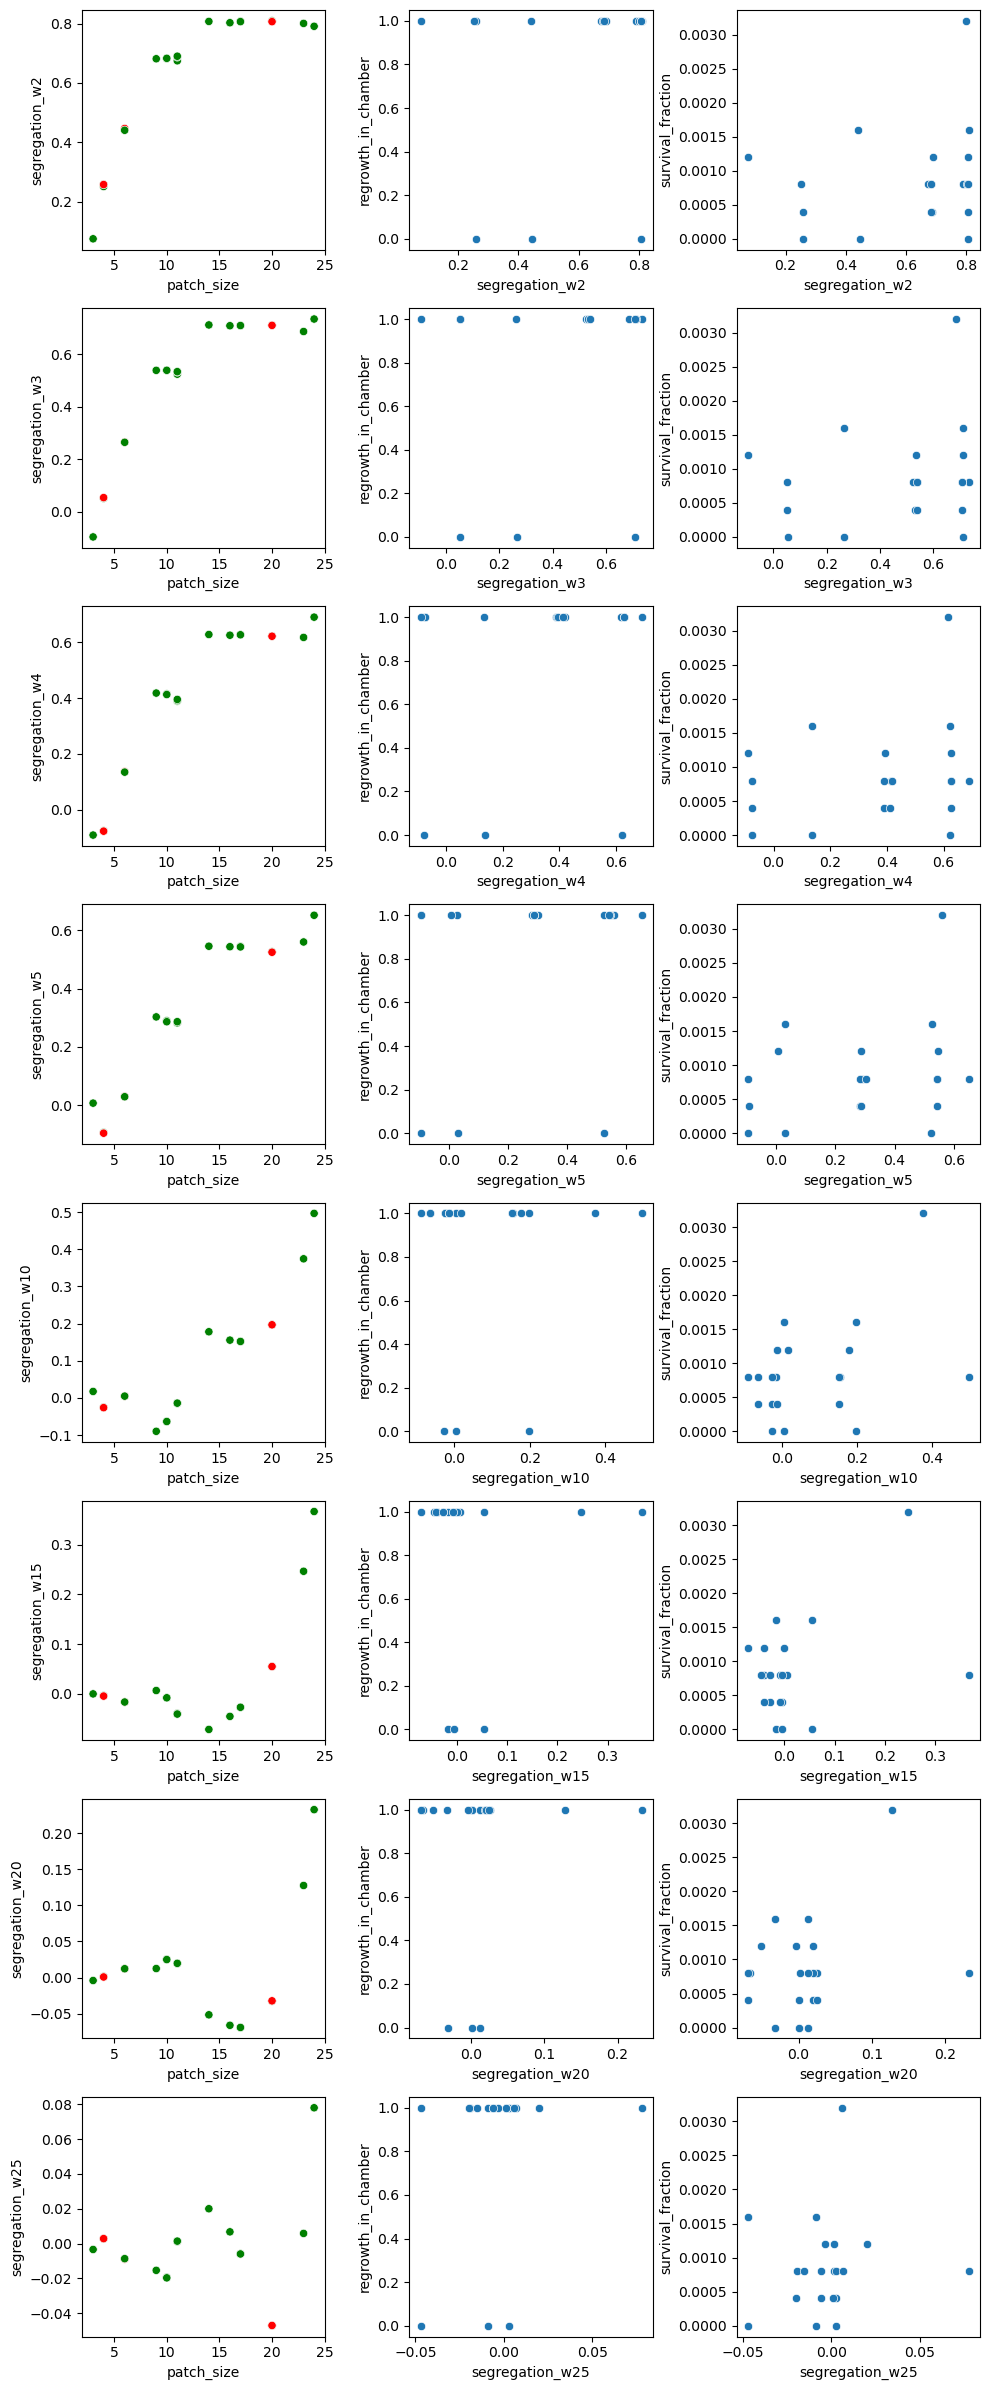

In [55]:
nw = len(window_sizes)
fig, axs =  plt.subplots(nw, 3, figsize=(10,nw*3))

for idx, w in enumerate(window_sizes):
    sns.scatterplot(data=df_aggregated, x='patch_size', y=f'segregation_w{w}', hue='regrowth_in_chamber', ax=axs[idx, 0], palette={True: 'green', False: 'red'})
    axs[idx, 0].get_legend().remove()
    sns.scatterplot(data=df_aggregated, x=f'segregation_w{w}', y='regrowth_in_chamber', ax=axs[idx, 1])
    sns.scatterplot(data=df_aggregated, x=f'segregation_w{w}', y='survival_fraction', ax=axs[idx, 2])

plt.tight_layout()